## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import glob
import matplotlib as plt
from collections import OrderedDict
import random

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import glob, os
from sklearn.model_selection import train_test_split


from Utils import *

## Subject 1 Data and Events Loading 

In [2]:
load_data,load_labels = load_data(subject_count=6)

Subject 1:  38%|███▊      | 3/8 [00:01<00:03,  1.52it/s]


KeyboardInterrupt: 

In [ ]:
for i in range(len(load_labels)):
    df_copy = load_labels[i].copy()
    df_copy['sum'] = df_copy.sum(axis=1)
    df_copy = df_copy[df_copy['sum'] <= 1]
    df_copy = df_copy.drop(columns=['sum'])
    load_labels[i] = df_copy


In [ ]:
start_end = []
for data in load_labels:
    start_end_ = start_end_data_finder(data)
    start_end.append(start_end_)

In [ ]:
for i in range(6):
    for key, value in start_end[i].items():
        new_value = []
        found_pair = False
        for idx in range(0, len(value), 2):
            if idx + 1 < len(value):
                a = value[idx + 1] - value[idx]
                if a > 50 :
                    x = value[idx]
                    y = x + 50
                    new_value.extend([x, y])
                    found_pair = True
                elif a == 50:
                    new_value.extend([value[idx], value[idx + 1]])
                elif a < 50:
                    # If the difference is less than 50, remove these values
                    value[idx] = None
                    value[idx + 1] = None

        # Filter out None values (values less than 50) from the list
        new_value = [v for v in new_value if v is not None]
        start_end[i][key] = new_value


In [ ]:
all_extracted_data = []
for i in range(len(start_end)):
    extracted_data = data_extractor(start_end[i],load_data[i])
    all_extracted_data.append(extracted_data)

In [ ]:
class_data = {}

for class_idx in range(6):
    class_data[class_idx] = []

for id, sublist in enumerate(all_extracted_data):
    for idx, secondary_list in enumerate(sublist):
        class_data[idx].append(len(secondary_list))

for class_idx, lengths in class_data.items():
    total_length = sum(lengths)
    print(f"Class {class_idx}: Data points = {total_length}")


Class 0: Data points = 1560
Class 1: Data points = 707
Class 2: Data points = 472
Class 3: Data points = 1447
Class 4: Data points = 1260
Class 5: Data points = 1260


In [ ]:
# Initialize an empty dictionary to store data
data_dict = {i: [] for i in range(6)}

# Loop through all_extracted_data and populate data_dict
for id, sublist in enumerate(all_extracted_data):
    for idx, secondary_list in enumerate(sublist):
        data_dict[id].append(secondary_list)

# Initialize a combined dictionary
combined_dict = {}

# Combine the sublists and store them in the combined_dict
for key in data_dict:
    combined_list = []
    for sublist in data_dict[key]:
        combined_list.extend(sublist)
    combined_dict[key] = combined_list


In [ ]:
min_length = min(len(combined_dict[i]) for i in range(len(combined_dict)))
min_length


963

In [ ]:
no_events_data_extracted = []
for idx, subj_data in enumerate(load_data):
    no_event = data_extractor_noevent(subj_data, load_labels[idx], min_length)
    no_events_data_extracted.append(no_event)


In [ ]:
class_labels = np.ones(min_length*6)

for i in range(6):
    class_labels[i*min_length:(i+1)*min_length] = class_labels[i*min_length:(i+1)*min_length] *(i)

noevent_label = np.ones(min_length)*(6)

all_class_labels = np.concatenate((class_labels,noevent_label))

In [ ]:
labels = all_class_labels[:-3]
len(all_class_labels),all_class_labels

(6741, array([0., 0., 0., ..., 6., 6., 6.]))

In [ ]:
import random
import math

# Shuffle and concatenate data from combined_dict
selected_data = []
for key in combined_dict:
    # Shuffle the data points within each class
    random.shuffle(combined_dict[key])
    
    # Append the first `min_length` data points to the selected_data list
    selected_data.extend(combined_dict[key][:min_length])

# Shuffle and concatenate data from no_events_data_extracted
for arr in no_events_data_extracted:
    # Check if the current array has enough data to select min_length/6 points
        # Shuffle the data points within the array
    random.shuffle(arr)
    
    # Append the first `min_length/6` data points to the selected_data list
    selected_data.extend(arr[:int(min_length/6)])
selected_data.extend([])


In [ ]:
len(selected_data[5]),len(selected_data[3])

(51, 51)

In [ ]:
len(selected_data),type(selected_data),len(labels),type(labels)

(6738, list, 6738, numpy.ndarray)

In [ ]:
selected_data = np.reshape(np.array(selected_data),(selected_data.shape[0],selected_data.shape[1]*selected_data.shape[2]))

In [ ]:
print("selected_data shape:", selected_data.shape)
print("labels shape:", labels.shape)
print("selected_data data type:", selected_data.dtype)
print("labels data type:", labels.dtype)

selected_data shape: (6738, 1632)
labels shape: (6738,)
selected_data data type: int64
labels data type: float64


## Data preprocessing

In [ ]:
# start_end_data = start_end_data_finder(all_labels)
# data_extracted_occurances = np.reshape(data_extractor(start_end_data,all_data),(6*260,150,32) )

# no_events_data_extracted = data_extractor_noevent(all_data, all_labels,1560)
# final_data = np.empty(1560*150*32)
# final_data = np.concatenate((data_extracted_occurances,no_events_data_extracted))
# final_data = np.reshape(final_data, (3120,150*32))

# class_labels = np.ones(1560)

# for i in range(6):
#     class_labels[i*260:(i+1)*260] = class_labels[i*260:(i+1)*260] *(i)

# noevent_label = np.ones(1560)*(6)

# all_class_labels = np.concatenate((class_labels,noevent_label))


#### Scaling and Shuffling

In [ ]:

from sklearn.preprocessing import StandardScaler
all_data_shuffled , all_labels_shuffled = shuffle(selected_data, labels, random_state = 0)


ss = StandardScaler()
all_data_shuffled_scaled = ss.fit_transform(all_data_shuffled)


### Dimentionality reduction

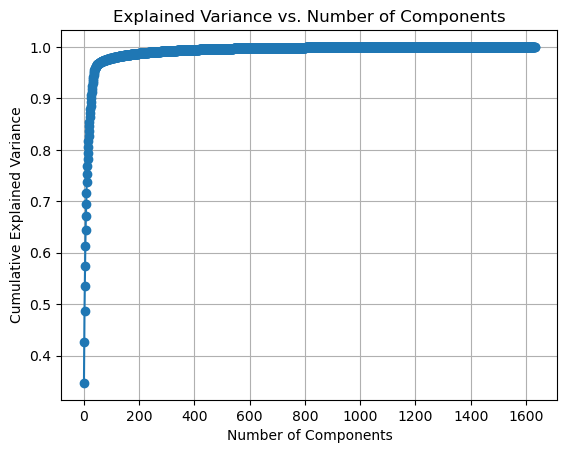

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()

pca.fit(all_data_shuffled_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()


In [ ]:
n_components = 100
pca = PCA(n_components = n_components)
pca.fit(all_data_shuffled)
pca_tr = pca.fit_transform(all_data_shuffled_scaled)

## Model Analysis

#### Support Vector machines

Accuracy: 0.9725519287833828


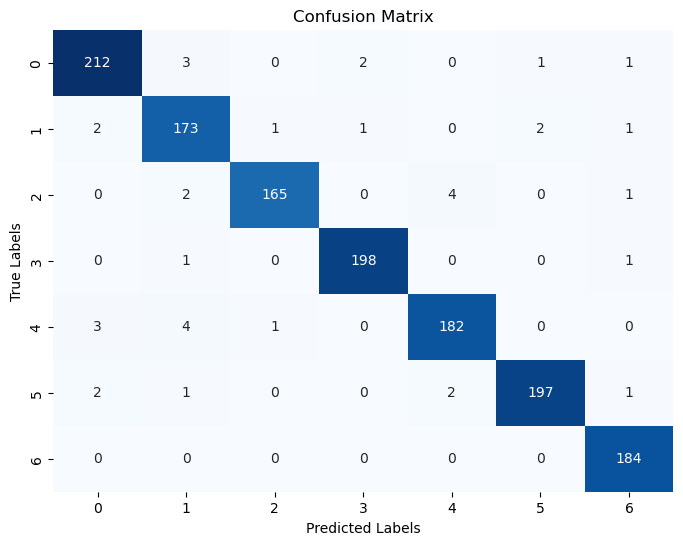

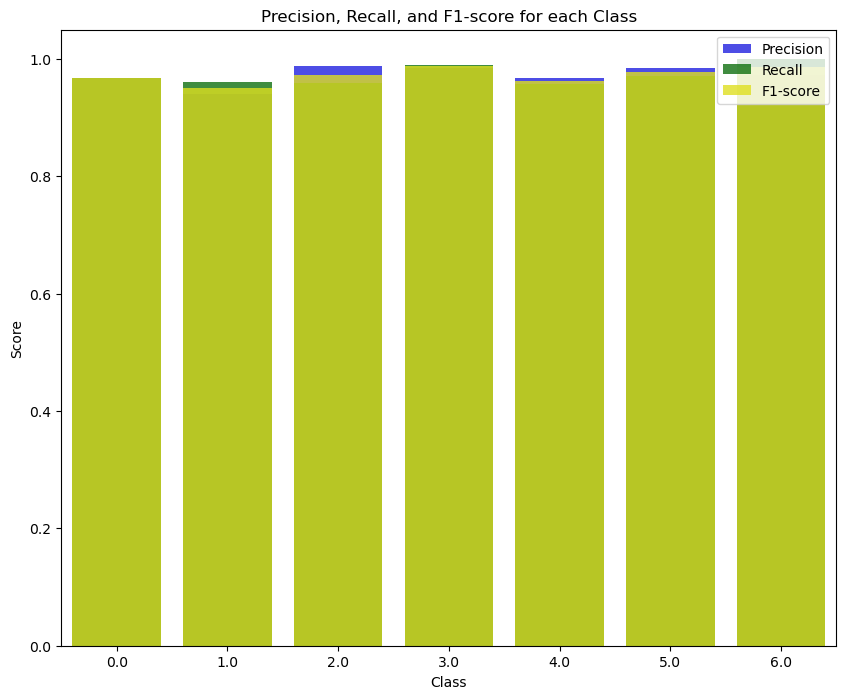

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       219
         1.0       0.94      0.96      0.95       180
         2.0       0.99      0.96      0.97       172
         3.0       0.99      0.99      0.99       200
         4.0       0.97      0.96      0.96       190
         5.0       0.98      0.97      0.98       203
         6.0       0.97      1.00      0.99       184

    accuracy                           0.97      1348
   macro avg       0.97      0.97      0.97      1348
weighted avg       0.97      0.97      0.97      1348



In [ ]:
from sklearn.svm import SVC

model = SVC(kernel="rbf")
evaluate_model(model, all_data_shuffled_scaled, all_labels_shuffled)

Accuracy: 0.9718100890207715


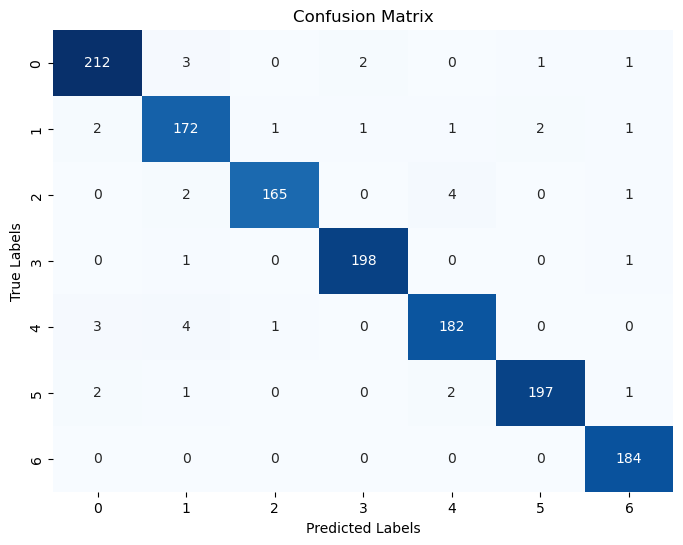

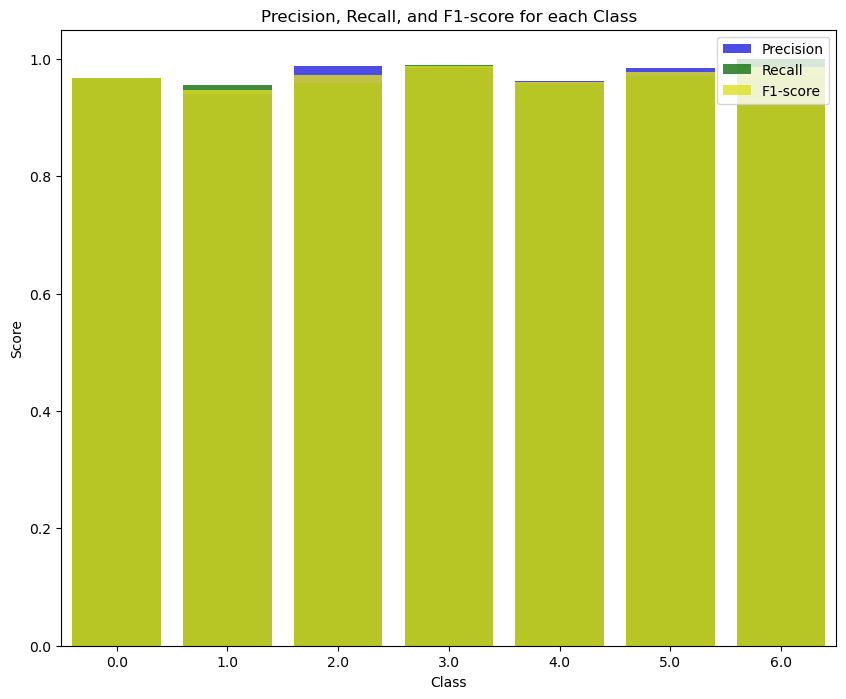

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       219
         1.0       0.94      0.96      0.95       180
         2.0       0.99      0.96      0.97       172
         3.0       0.99      0.99      0.99       200
         4.0       0.96      0.96      0.96       190
         5.0       0.98      0.97      0.98       203
         6.0       0.97      1.00      0.99       184

    accuracy                           0.97      1348
   macro avg       0.97      0.97      0.97      1348
weighted avg       0.97      0.97      0.97      1348



In [ ]:
model = SVC(kernel="rbf")
evaluate_model(model, pca_tr, all_labels_shuffled)

#### Random Forest Model


Accuracy: 0.9614243323442137


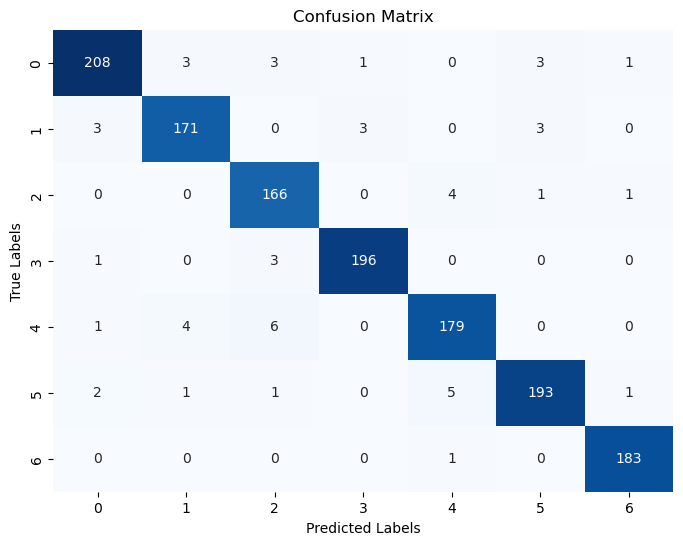

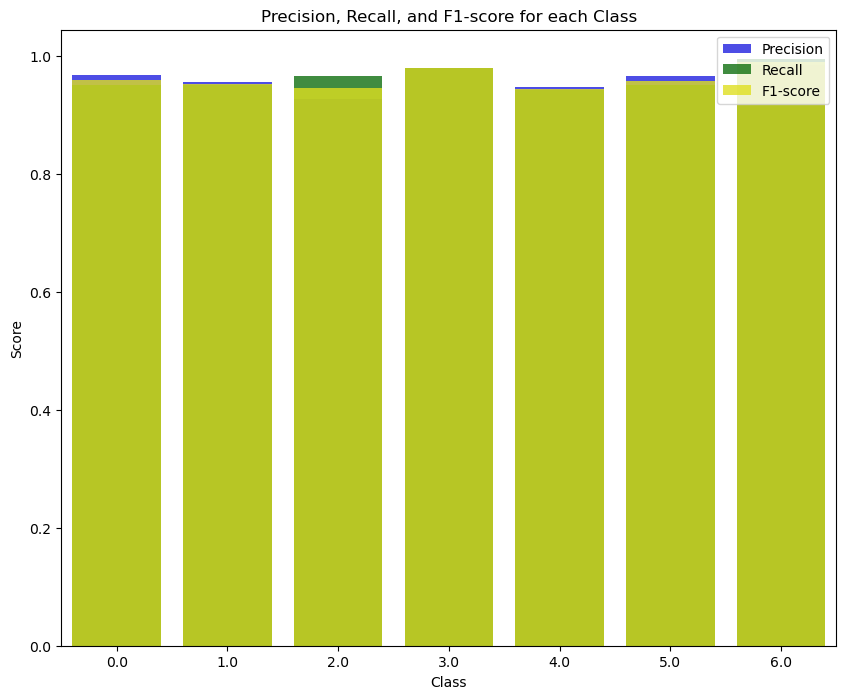

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       219
         1.0       0.96      0.95      0.95       180
         2.0       0.93      0.97      0.95       172
         3.0       0.98      0.98      0.98       200
         4.0       0.95      0.94      0.94       190
         5.0       0.96      0.95      0.96       203
         6.0       0.98      0.99      0.99       184

    accuracy                           0.96      1348
   macro avg       0.96      0.96      0.96      1348
weighted avg       0.96      0.96      0.96      1348



In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000)
evaluate_model(model, pca_tr, all_labels_shuffled)

#### K nearest neighbor
**n_neighbors** : A common heuristic is to use the square root of the number of data points in the dataset as the k-value. fo this case k=√3000 ≈ 54.

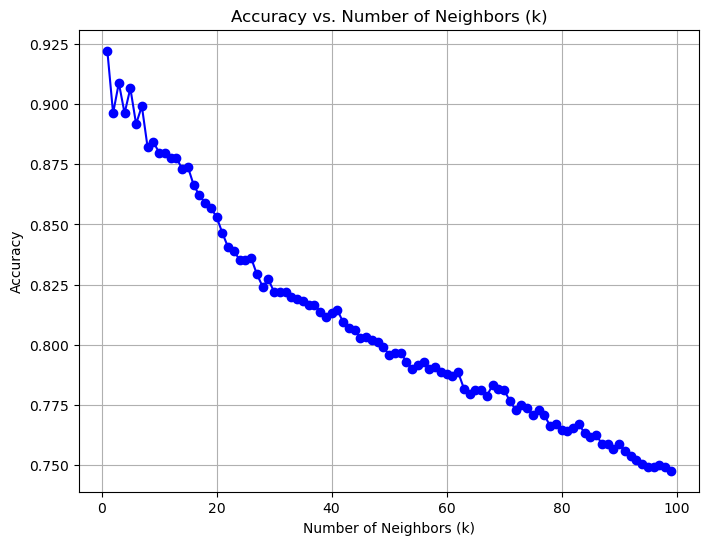

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_tr, all_labels_shuffled, test_size=0.2, random_state=42)

# Initialize lists to store accuracy scores for different k values
k_values = list(range(1, 100))
accuracy_scores = []

# Loop through different k values
for k in k_values:
    # Create and fit the k-NN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = knn.predict(X_test)
    
    # Calculate accuracy and store it
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Plot the accuracy scores for different k values
plt.figure(figsize=(8, 6))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors (k)')
plt.grid(True)
plt.show()


Accuracy: 0.7885756676557863


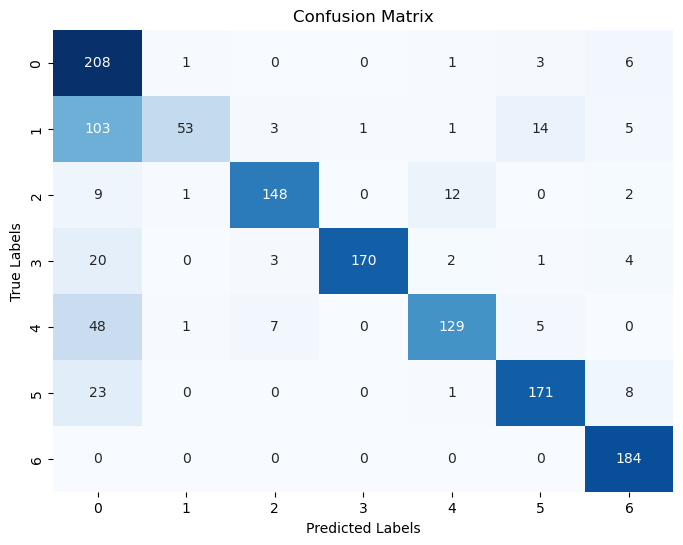

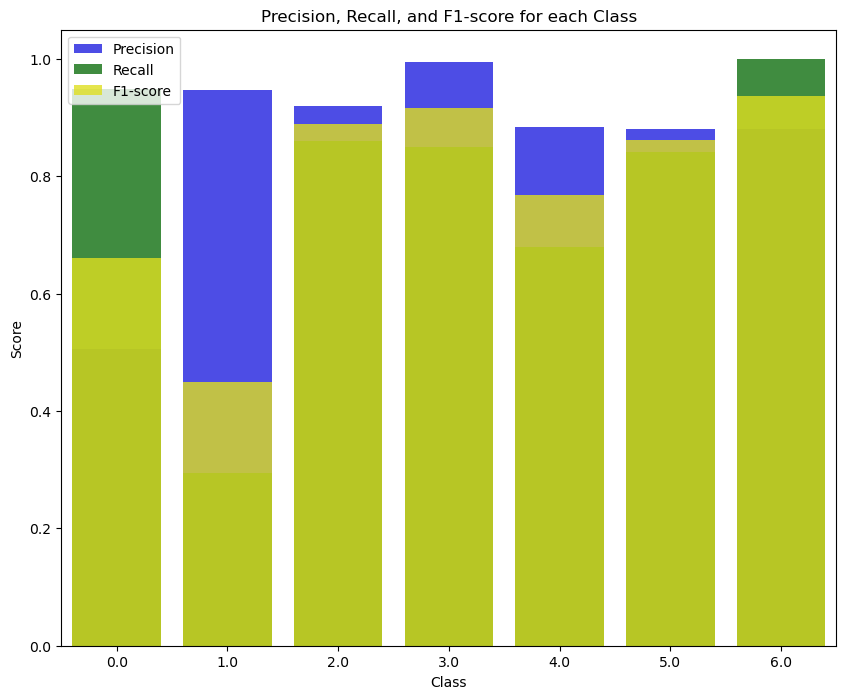

Classification Report:
              precision    recall  f1-score   support

         0.0       0.51      0.95      0.66       219
         1.0       0.95      0.29      0.45       180
         2.0       0.92      0.86      0.89       172
         3.0       0.99      0.85      0.92       200
         4.0       0.88      0.68      0.77       190
         5.0       0.88      0.84      0.86       203
         6.0       0.88      1.00      0.94       184

    accuracy                           0.79      1348
   macro avg       0.86      0.78      0.78      1348
weighted avg       0.85      0.79      0.78      1348



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

model = KNeighborsClassifier(n_neighbors = 8)
evaluate_model(model, pca_tr, all_labels_shuffled)

#### XGBoost

Accuracy: 0.9443620178041543


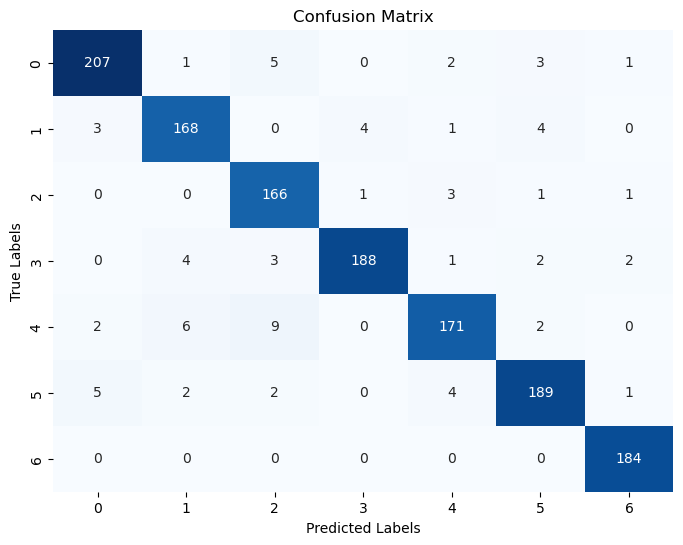

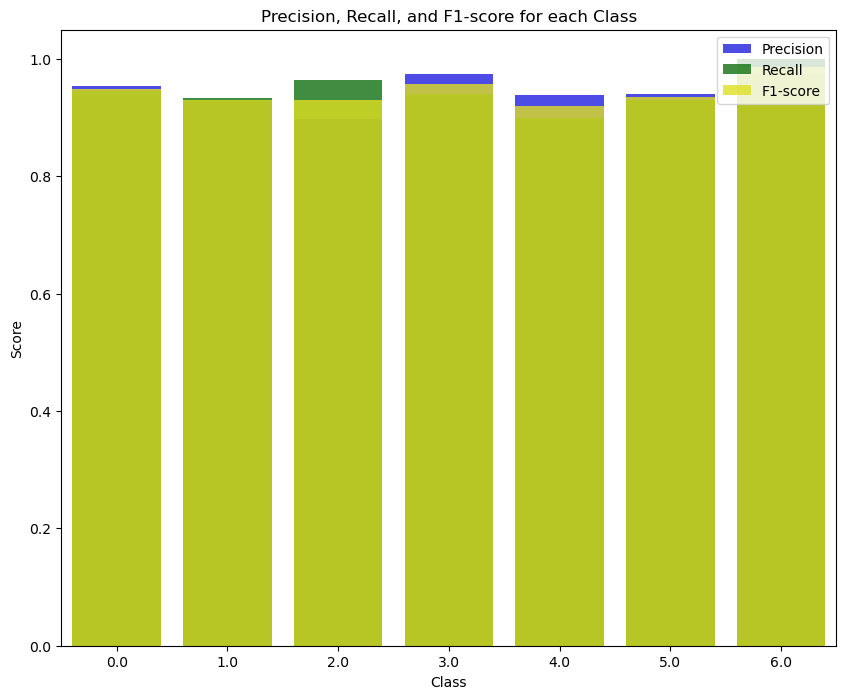

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       219
         1.0       0.93      0.93      0.93       180
         2.0       0.90      0.97      0.93       172
         3.0       0.97      0.94      0.96       200
         4.0       0.94      0.90      0.92       190
         5.0       0.94      0.93      0.94       203
         6.0       0.97      1.00      0.99       184

    accuracy                           0.94      1348
   macro avg       0.94      0.94      0.94      1348
weighted avg       0.94      0.94      0.94      1348



In [ ]:
import xgboost as xgb
params = {
    'objective': 'multi:softmax',  # Multi-class classification objective
    'num_class': 7,                # Number of classes in the multi-class problem
    'eval_metric': 'mlogloss',     # Multiclass Logarithmic Loss
    'eta': 0.1,                    # Learning rate
    'max_depth': 3,                # Maximum depth of a tree
    'subsample': 0.8,              # Subsample ratio of the training instances
    'colsample_bytree': 0.8,       # Subsample ratio of columns when constructing each tree
    'seed': 42                     # Random seed for reproducibility
}

xgb_model = xgb.XGBClassifier(**params)
evaluate_model(xgb_model, pca_tr, all_labels_shuffled)